In [1]:
%matplotlib inline

In [2]:
import glob
import os
import subprocess
import numpy as np
from scipy import ndimage
from scipy import signal
from scipy.misc import imsave
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import rotate, resize
import time
import pylab as pl
from IPython import display
import librosa
import cPickle
import pandas as pd

### Convert pdf to png

Requires use of ImageMagick's convert command line tool

In [3]:
root_dir = 'score_data'
pdf_dir = root_dir + '/prepped_pdf' # directory containing pdfs of scores
png_dir = root_dir + '/prepped_png' # root output directory for png files

In [1]:
#os.mkdir(png_dir)
pdf_files = glob(pdf_dir + '/*.pdf')
for pdf_file in pdf_files:
    basename = os.path.splitext(os.path.basename(pdf_file))[0]
    pngout = png_dir + '/' + basename + '.png'
    subprocess.call(['convert', '-density', '72', pdf_file, pngout]) # 72 dpi is the default value

NameError: name 'glob' is not defined

### Rotate to ensure horizontal lines

In [3]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [4]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray', vmin=0, vmax=1)

In [5]:
def rotateToHorizontal(img, lb=-2, ub=2, incr=.01, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

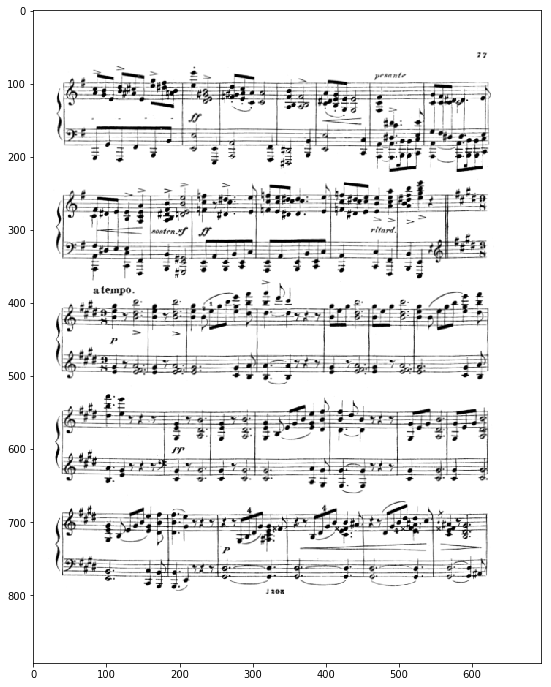

In [6]:
I = importImage('score_data/prepped_png/score17.png')
Irot, theta = rotateToHorizontal(I,-1,1)
showImage(Irot)

In [7]:
def rotateAllImages(indir, outdir):
    png_files = glob.glob(indir + '/*.png')
    for png_file in png_files:
        I = importImage(png_file)
        Irot, theta = rotateToHorizontal(I)
        img = 255 - np.uint8(Irot*255)
        basename = os.path.basename(png_file)
        pngout = outdir + '/' + basename
        imsave(pngout,img)

In [18]:
pngrot_dir = root_dir + '/toAnnotate' # rotated png files

In [59]:
os.mkdir(pngrot_dir)
rotateAllImages(png_dir, pngrot_dir)

### Annotation

The rotated png files are manually annotated.  We record the following information:
- Note head pixel locations
- Sharp/flat/natural sign pixel locations
- Barline pixel locations
- Note head durations (in beats)
- Spacing between top and bottom horizontal lines in a single staff
- Time signature of piece

The annotations can be found in the annot_data folder.

### Create note head database

In [6]:
def getNoteHeadSize(staffH):
    h = staffH * .25
    w = h * 1.2
    return (h,w)

In [7]:
def extractNoteHeadImage(I, row, col, noteSize, scale_factor = 1):
    rowStart = np.max([0, np.int(np.round(row - noteSize[0] * .5 * scale_factor))])
    rowEnd = np.min([I.shape[0], rowStart + np.int(np.round(noteSize[0] * scale_factor))])
    colStart = np.max([0, np.int(np.round(col - noteSize[1] * .5 * scale_factor))])
    colEnd = np.min([I.shape[1], colStart + np.int(np.round(noteSize[1] * scale_factor))])
    crop = I[rowStart:rowEnd, colStart:colEnd]
    return crop

In [8]:
def extractNoteImages(df, scale_factor = 1.5, negative_sample = False):
    scoreids = pd.unique(df.filename)
    d = {}  # key: scoreid, value: image tensor
    coord = {}  # key: scoreid, value: list of (row,col) center pixel locations 
    for scoreid in scoreids:
        s = df[df.filename == scoreid]
        png_file = pngrot_dir + '/' + scoreid + '.png'
        I = importImage(png_file)
        noteSize = getNoteHeadSize(s.iloc[0].staff_height)
        if negative_sample:
            listValid = getListOfNonNoteRegions(I, s, noteSize)
        for i in range(s.shape[0]):
            if negative_sample:
                randIdx = np.random.randint(len(listValid))
                vpix = listValid[randIdx][0]
                hpix = listValid[randIdx][1]
            else:
                vpix = s.iloc[i].vpix
                hpix = s.iloc[i].hpix
            img = extractNoteHeadImage(I, vpix, hpix, noteSize, scale_factor)
            if i == 0:
                imgs = np.zeros((s.shape[0], img.shape[0], img.shape[1]))
                centers = []
            imgs[i,0:img.shape[0],0:img.shape[1]] = img
            centers.append((vpix, hpix))
        d[scoreid] = imgs
        coord[scoreid] = centers
    return d, coord

In [9]:
def getListOfNonNoteRegions(I, df, noteSize):
    A = np.zeros(I.shape) # 1 -> valid non-note region
    
    # enable allowable rows
    for v in pd.unique(df.vpix):
        rowStart = np.max([0, np.int(v - noteSize[0])])
        rowEnd = np.min([I.shape[0], np.int(v + noteSize[0])])
        A[rowStart:rowEnd,:] = 1
    
    # disable margins
    marginV = np.int(np.ceil(noteSize[0]))
    marginH = np.int(np.ceil(noteSize[1]))
    A[0:marginV,:] = 0
    A[I.shape[0]-marginV:,:] = 0
    A[:,0:marginH] = 0
    A[:,I.shape[1]-marginH:] = 0
    
    # disable note regions
    (vdelta, hdelta) = (np.int(noteSize[0]*.33), np.int(noteSize[1]*.33))
    for i in range(df.shape[0]):
        hpix = df.iloc[i].hpix
        vpix = df.iloc[i].vpix
        rowStart = np.max([0, vpix - vdelta])
        rowEnd = np.min([I.shape[0], vpix + vdelta])
        colStart = np.max([0, hpix - hdelta])
        colEnd = np.min([I.shape[1], hpix + hdelta])
        A[rowStart:rowEnd, colStart:colEnd] = 0
    
    # disable pure white regions
    eps = 0.01
    filt2d = np.ones((np.int(noteSize[0]), np.int(noteSize[1])))
    conv = convolve2d(I, filt2d, mode='same')
    A[conv < eps*filt2d.shape[0]*filt2d.shape[1]] = 0
    
    # assemble list of valid non-note regions
    result = [(r,c) for r in range(A.shape[0]) for c in range(A.shape[1]) if A[r,c] == 1]
    
    return result

In [10]:
def showRandomSample(d, rows = 4, cols = 4, scoreid = None):
    fig=plt.figure(figsize=(12, 12))
    scoreids = d.keys()
    for i in range(1, cols*rows +1):
        if scoreid is None:  # if not specified, select a score at random
            scoreid = scoreids[ np.random.randint(len(scoreids)) ]
        tensor = d[scoreid]
        randIdx = np.random.randint(tensor.shape[0])
        img = tensor[randIdx,:,:]
        fig.add_subplot(rows, cols, i)
        plt.imshow(1-img, cmap='gray', vmin=0, vmax=1)
        plt.title('%s %d' % (scoreid, randIdx))
    plt.show()

In [11]:
def viewContext(scoreid, coords, idx, delta):
    I = importImage('score_data/toAnnotate/%s.png' % scoreid)
    center = coords[scoreid][idx]
    showImage(I[center[0]-delta:center[0]+delta, center[1]-delta:center[1]+delta], sz=(4,4))

In [12]:
note_annot_file = 'annot_data/note_annot.csv'
df = pd.read_csv(note_annot_file)

IOError: File annot_data/note_annot.csv does not exist

In [20]:
dpos, pcoords = extractNoteImages(df)

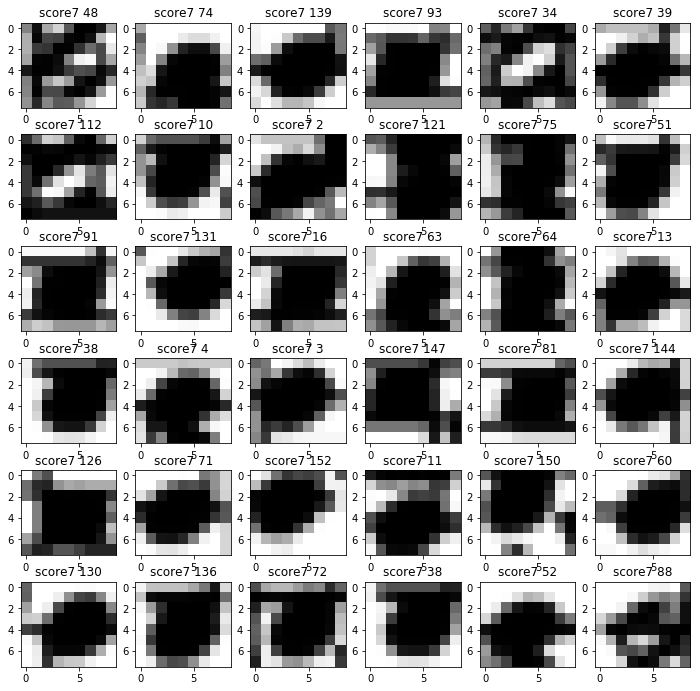

In [66]:
showRandomSample(dpos, 6, 6, scoreid='score7')

In [23]:
np.random.seed(0)
dneg, ncoords = extractNoteImages(df, negative_sample = True)

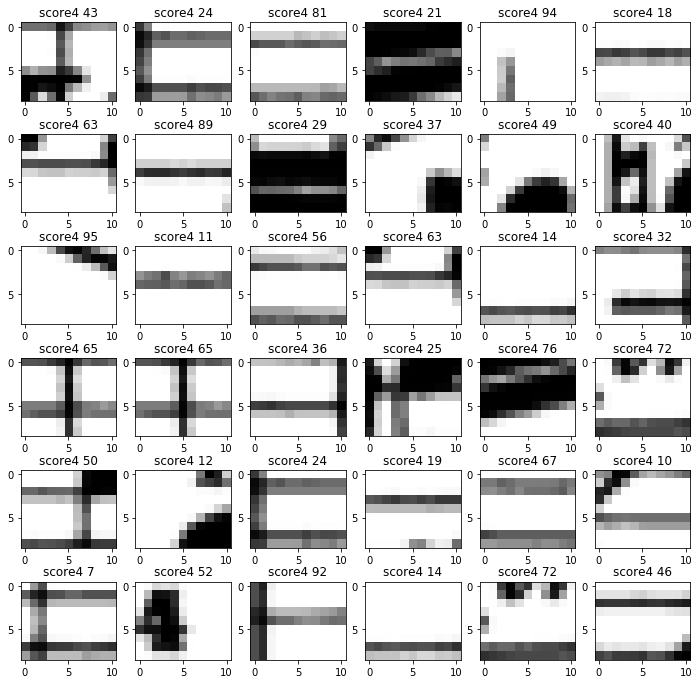

In [64]:
showRandomSample(dneg, 6, 6)

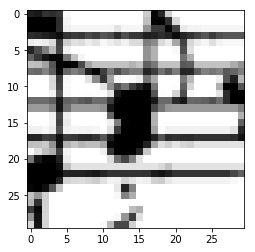

In [36]:
viewContext('score8', ncoords, 22, 15)

Resize all images to same dimensions

In [37]:
def resizeImages(d, outDims):
    r = {}
    for scoreid in d:
        tensor = d[scoreid]
        numImages = tensor.shape[0]
        r[scoreid] = np.zeros((numImages, outDims[0], outDims[1]))
        for i in range(numImages):
            r[scoreid][i,:,:] = resize(tensor[i,:,:], outDims)
    return r

In [38]:
scaledSize = (15,15)
dpos_scaled = resizeImages(dpos, scaledSize)

/Users/tjtsai/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


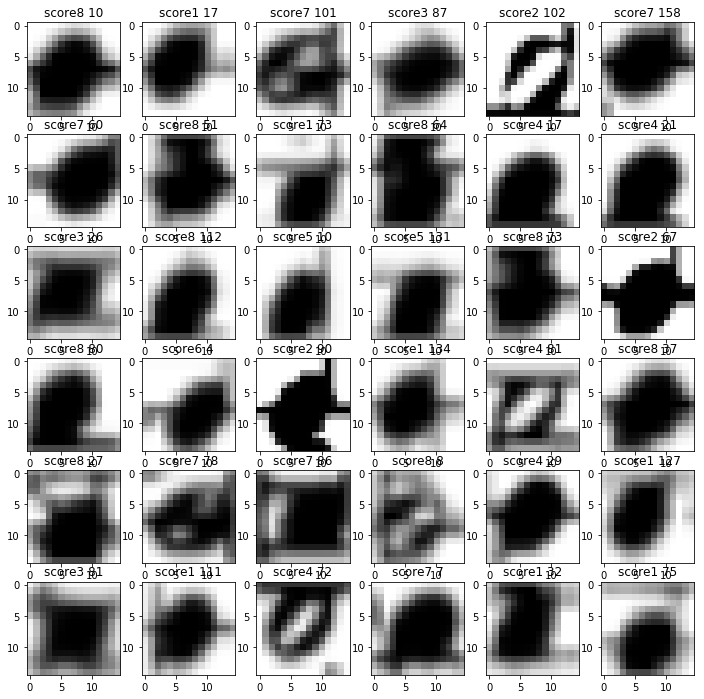

In [40]:
showRandomSample(dpos_scaled, 6, 6)

In [41]:
dneg_scaled = resizeImages(dneg, scaledSize)

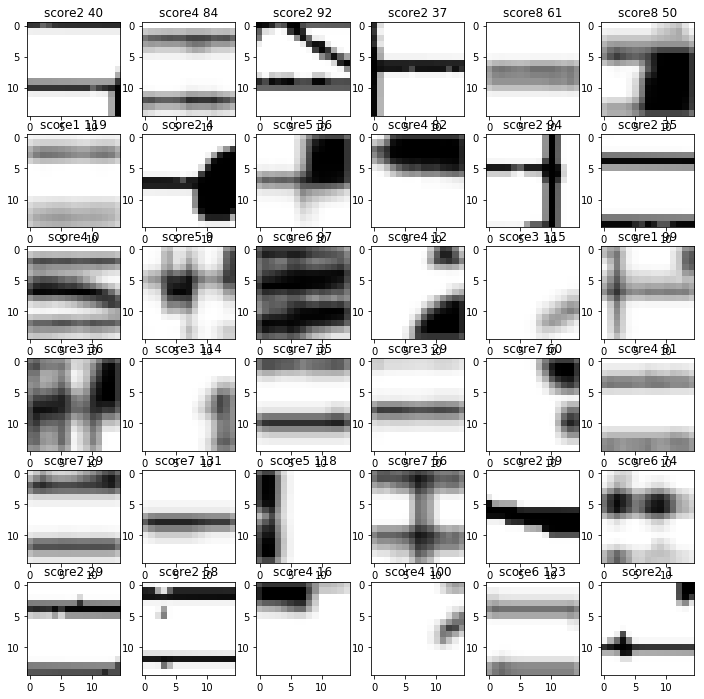

In [42]:
showRandomSample(dneg_scaled, 6, 6)

### Save images to file

In [43]:
saveFilePos = 'pkl_data/notes_pos.pkl'
saveFileNeg = 'pkl_data/notes_neg.pkl'

In [44]:
with open(saveFilePos, 'wb') as h:
    cPickle.dump(dpos_scaled, h)

In [45]:
with open(saveFileNeg, 'wb') as h:
    cPickle.dump(dneg_scaled, h)